In [1]:
!git clone https://github.com/millermuttu/torch_soft.git
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

Cloning into 'torch_soft'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 97 (delta 23), reused 81 (delta 12), pack-reused 0
Unpacking objects: 100% (97/97), done.
     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 952kB 4.6MB/s 
albumentations==0.4.6 is successfully installed


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-imagenet-200/val/images/val_1598.JPEG  
  inflating: tiny-ima

In [3]:
cd '/content/torch_soft'

/content/torch_soft


In [4]:
import torch
import dataset
import models
import utils
import visual
import gradcam
import numpy as np
from torchvision import transforms
from train_test import train, test, train_ocp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.datasets as datasets
import torch.utils.data as data
from torch.utils.data import DataLoader

In [5]:
cuda, device = utils.misc.initialize_device(utils.config.SEED)
train_path = "/content/tiny-imagenet-200/train"
val_path = "/content/tiny-imagenet-200/val"

GPU Available? True


In [6]:
# setting the configs
utils.config.BATCH_SIZE = 512
utils.config.EPOCHS = 50
utils.config.NUM_WORKERS = 16

In [7]:
# normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# # [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

augmentation = transforms.RandomApply([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64)], p=.8)

training_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    augmentation,
    transforms.ToTensor()])

valid_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor()])

In [8]:
in_memory = False

In [9]:
root = '/content/tiny-imagenet-200'
training_set = dataset.TinyImageNet(root, 'train', transform=training_transform, in_memory=in_memory)
valid_set = dataset.TinyImageNet(root, 'val', transform=valid_transform, in_memory=in_memory)

In [10]:
trainloader = DataLoader(training_set, batch_size=utils.config.BATCH_SIZE, shuffle=True, num_workers=utils.config.NUM_WORKERS)
validloader = DataLoader(valid_set, batch_size=utils.config.BATCH_SIZE, num_workers=utils.config.NUM_WORKERS)

In [11]:
model = models.ResNet18(num_classes=len(training_set.label_texts)).to(device)
utils.misc.summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [12]:
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=1E-5)

In [13]:
lr_finder = utils.lr_finder.LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.27E+00


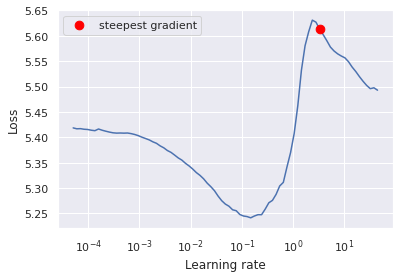

(<matplotlib.axes._subplots.AxesSubplot at 0x7f30602baa58>, 3.274549162877727)

In [14]:
lr_finder.plot()

In [15]:
# reset the lr graph
lr_finder.reset()

In [16]:
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=1)
scheduler = utils.misc.one_cycle_lr(optimizer=optimizer,max_lr=5E-01,epochs=utils.config.EPOCHS,steps_per_epoch=len(trainloader),pct_start=0.5,div_factor=10,final_div_factor=5)
# scheduler = utils.misc.ReduceLROnPlateau(optimizer=optimizer,patience=2,min_lr=1E-6,verbose=True)
# scheduler = utils.misc.StepLR_scheduler(optimizer,10)
if utils.config.DEBUG == True:
    utils.config.EPOCHS = 15

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(utils.config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{utils.config.EPOCHS}\n")
    train_ocp(model, trainloader, optimizer,scheduler, loss_fn, device, train_losses, train_accuracy)
    # train(model, trainloader, optimizer, loss_fn, device, train_losses, train_accuracy)
    # scheduler.step()
    tl = test(model, validloader, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
    # scheduler.step(test_loss[epoch])

  0%|          | 0/196 [00:00<?, ?it/s]

Running Epoch 1/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0101, Accuracy: 490/10000 (4.90%)

Running Epoch 2/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0083, Accuracy: 1100/10000 (11.00%)

Running Epoch 3/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 1161/10000 (11.61%)

Running Epoch 4/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0072, Accuracy: 2017/10000 (20.17%)

Running Epoch 5/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 1964/10000 (19.64%)

Running Epoch 6/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0060, Accuracy: 3037/10000 (30.37%)

Running Epoch 7/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0059, Accuracy: 3140/10000 (31.40%)

Running Epoch 8/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 3015/10000 (30.15%)

Running Epoch 9/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0054, Accuracy: 3615/10000 (36.15%)

Running Epoch 10/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0053, Accuracy: 3771/10000 (37.71%)

Running Epoch 11/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0054, Accuracy: 3734/10000 (37.34%)

Running Epoch 12/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 4026/10000 (40.26%)

Running Epoch 13/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 4360/10000 (43.60%)

Running Epoch 14/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 4376/10000 (43.76%)

Running Epoch 15/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 4415/10000 (44.15%)

Running Epoch 16/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 4724/10000 (47.24%)

Running Epoch 17/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 4354/10000 (43.54%)

Running Epoch 18/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 4809/10000 (48.09%)

Running Epoch 19/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 4721/10000 (47.21%)

Running Epoch 20/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 4828/10000 (48.28%)

Running Epoch 21/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 4701/10000 (47.01%)

Running Epoch 22/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 4933/10000 (49.33%)

Running Epoch 23/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5037/10000 (50.37%)

Running Epoch 24/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5083/10000 (50.83%)

Running Epoch 25/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5224/10000 (52.24%)

Running Epoch 26/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 5239/10000 (52.39%)

Running Epoch 27/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5193/10000 (51.93%)

Running Epoch 28/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5279/10000 (52.79%)

Running Epoch 29/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5293/10000 (52.93%)

Running Epoch 30/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0042, Accuracy: 5379/10000 (53.79%)

Running Epoch 31/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5371/10000 (53.71%)

Running Epoch 32/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5306/10000 (53.06%)

Running Epoch 33/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5448/10000 (54.48%)

Running Epoch 34/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5419/10000 (54.19%)

Running Epoch 35/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0043, Accuracy: 5471/10000 (54.71%)

Running Epoch 36/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 5402/10000 (54.02%)

Running Epoch 37/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5628/10000 (56.28%)

Running Epoch 38/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5607/10000 (56.07%)

Running Epoch 39/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5596/10000 (55.96%)

Running Epoch 40/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5664/10000 (56.64%)

Running Epoch 41/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 5673/10000 (56.73%)

Running Epoch 42/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 5676/10000 (56.76%)

Running Epoch 43/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5742/10000 (57.42%)

Running Epoch 44/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5734/10000 (57.34%)

Running Epoch 45/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0045, Accuracy: 5862/10000 (58.62%)

Running Epoch 46/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5850/10000 (58.50%)

Running Epoch 47/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5887/10000 (58.87%)

Running Epoch 48/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5930/10000 (59.30%)

Running Epoch 49/50



  0%|          | 0/196 [00:00<?, ?it/s]


Validation set: Average loss: 0.0044, Accuracy: 5890/10000 (58.90%)

Running Epoch 50/50



Loss=0.69 Batch_ID=195 Accuracy=81.56: 100%|██████████| 196/196 [02:59<00:00,  1.09it/s]



Validation set: Average loss: 0.0044, Accuracy: 5902/10000 (59.02%)



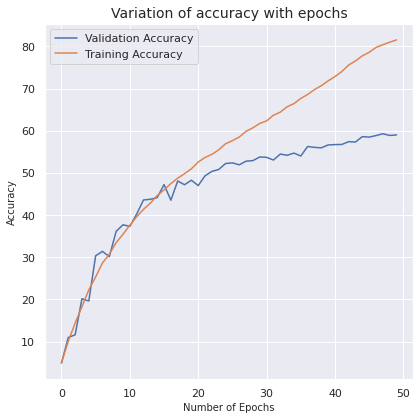

In [17]:
visual.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")